<a href="https://colab.research.google.com/github/Wishmi-Sasika/MLOM-Labs/blob/main/FDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import joblib

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/FDM_Project/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [ ]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print('Number of rows: ', df.shape[0])
    print("\nNumber of Columns:", df.shape[1])
    print("\nData Features:")
    print(df.columns.tolist())
    print("\nData Types:\n",data.dtypes)
    print("\nDupicate Values:",data.duplicated().sum())
    print("\nUnique values:")
    print(df.nunique())

dataoveriew(data, 'Overview of the dataset')

Overview of the dataset:

Number of rows:  7043

Number of Columns: 21

Data Features:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn          

# Finding Null Values

In [ ]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Explore target variable

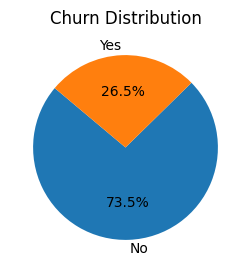

In [ ]:
churn_counts = data['Churn'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Churn Distribution')
plt.show()

# Compare categorical variables with churn column

In [ ]:
#Defining bar chart function
def bar(feature, df=data ):
    #Groupby the categorical feature
    temp_df = df.groupby([feature, 'Churn']).size().reset_index()
    temp_df = temp_df.rename(columns={0:'Count'})
    #Calculate the value counts of each distribution and it's corresponding Percentages
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]
    #Calculate the value counts of each distribution and it's corresponding Percentages
    num_list = [num[1][1] for num in value_counts_df.iterrows()]
    div_list = [element / sum(num_list) for element in num_list]
    percentage = [round(element * 100,1) for element in div_list]
    #Defining string formatting for graph annotation
    #Numeric section
    def num_format(list_instance):
        formatted_str = ''
        for index,num in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{num}%, ' #append to empty string(formatted_str)
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{num}% & '
            else:
                formatted_str=formatted_str+f'{num}%'
        return formatted_str
    #Categorical section
    def str_format(list_instance):
        formatted_str = ''
        for index, cat in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{cat}, '
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{cat} & '
            else:
                formatted_str=formatted_str+f'{cat}'
        return formatted_str


    #Running the formatting functions
    num_str = num_format(percentage)
    cat_str = str_format(categories)

    #Setting graph framework
    fig = px.bar(temp_df, x=feature, y='Count', color='Churn', title=f'Churn rate by {feature}', barmode="group", color_discrete_sequence=["#3700B3", "#03DAC6"])
    fig.add_annotation(
                text=f'Value count of distribution of {cat_str} are<br>{num_str} percentage respectively.',
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=1.25,  # Adjust the x-coordinate to move the box to the left
                y=1.15,   # Adjust the y-coordinate to move the box higher or lower
                bordercolor='black',
                borderwidth=1)
    fig.update_layout(
        # margin space for the annotations on the right
        margin=dict(r=400),
    )

    return fig.show()

In [ ]:
bar('StreamingMovies')
bar('PaperlessBilling')
bar('Contract')
bar('Dependents')
bar('Partner')
bar('InternetService')
bar('PhoneService')
bar('gender')
bar('SeniorCitizen')


In [ ]:
#replace no internet service in to NO and no phone service in to No
data.replace('No internet service','No',inplace=True)
data.replace('No phone service','No',inplace=True)

In [ ]:
def print_unique_col_values(data):

 for column in data:
   if data[column].dtypes=='object':
     print(f'{column} : {data[column].unique()}')
print_unique_col_values(data)

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn : ['No' 'Yes']


In [ ]:
# Save the updated DataFrame to the CSV file
data.to_csv('/content/drive/MyDrive/FDM_Project/Telco-Customer-Churn.csv', index=False)

In [ ]:
bar('MultipleLines')
bar('OnlineSecurity')
bar('OnlineBackup')
bar('DeviceProtection')
bar('StreamingTV')
bar('StreamingMovies')
bar('TechSupport')

# Explore Numeric Features

In [ ]:
# Convert "TotalCharges" column to float
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

# Verify the updated data types
print(data.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [ ]:
# Fill missing values with the median
median_value = data["TotalCharges"].median()
data["TotalCharges"].fillna(median_value,inplace=True)

# Verify the updated column
print(data["TotalCharges"])

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64


In [ ]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
# Save the updated DataFrame to the CSV file
data.to_csv('/content/drive/MyDrive/FDM_Project/Telco-Customer-Churn.csv', index=False)

# Exploring the Outliers

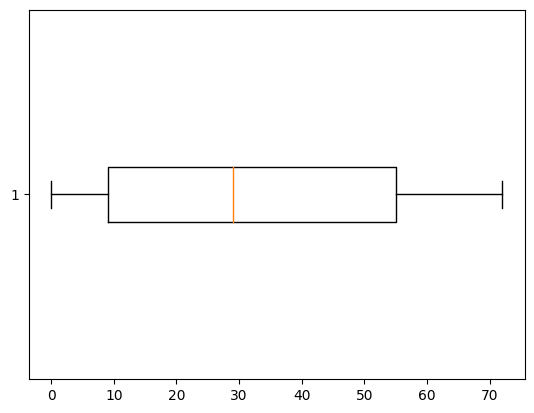

In [ ]:
plt.boxplot(data['tenure'],vert=False)
plt.show()

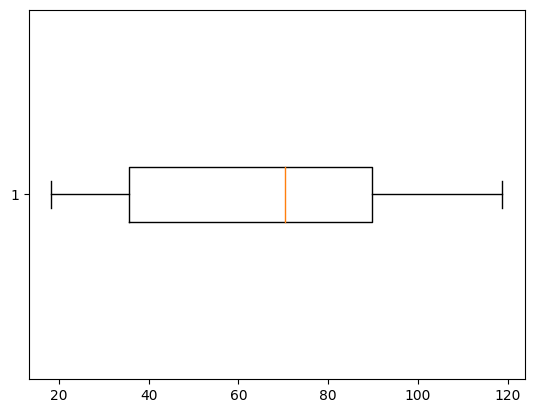

In [ ]:
plt.boxplot(data['MonthlyCharges'],vert=False)
plt.show()

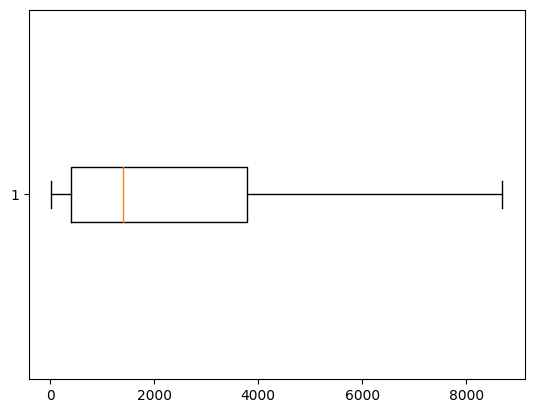

In [ ]:
plt.boxplot(data['TotalCharges'],vert=False)
plt.show()

It seems that there are no outliers in tenure , monthlycharges and totalcharges columns

# Data Transformation

Simplifying the dataset by binning on numerical variables (tenure, MonthlyCharges, and TotalCharges) and transforms them into categorical variables with three levels: 'low', 'medium', and 'high'.

In [ ]:
#Create an empty dataframe
bin_df = pd.DataFrame()

#Update the binning dataframe
bin_df['tenure_bins'] =  pd.qcut(data['tenure'], q=3, labels= ['low', 'medium', 'high'])
bin_df['MonthlyCharges_bins'] =  pd.qcut(data['MonthlyCharges'], q=3, labels= ['low', 'medium', 'high'])
bin_df['TotalCharges_bins'] =  pd.qcut(data['TotalCharges'], q=3, labels= ['low', 'medium', 'high'])
bin_df['Churn'] = data['Churn']

#Plot the bar chart of the binned variables
bar('tenure_bins', bin_df)
bar('MonthlyCharges_bins', bin_df)
bar('TotalCharges_bins', bin_df)


Based on binning, the low tenure and high monthly charge bins have higher churn rates as supported with the previous analysis. While the low Total charge bin has a higher churn rate.

# Data Preprocessing

In [ ]:
#Encording the Categorical Features

# yes and no replace with 1 and 0
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection',
                        'TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
  data[col].replace({'Yes':1,'No': 0},inplace=True)

#one hot encoding to other columns
data= pd.get_dummies(data=data,columns=['InternetService','Contract','PaymentMethod'])
data.columns

#geneder column
data['gender'].replace({'Female':0,'Male':1},inplace=True)

In [ ]:
# Save the updated DataFrame to the CSV file
data.to_csv('/content/drive/MyDrive/FDM_Project/Telco-Customer-Churn.csv', index=False)

In [ ]:
print(data.dtypes)

customerID                                  object
gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic    

In [ ]:
#reindexing the dataset
column_name = 'Churn'

# Get a list of column names excluding the column to be moved
other_columns = [col for col in data.columns if col != column_name]

# Reorder the DataFrame with the column moved to the last position
data = data[other_columns + [column_name]]

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,7590-VHVEG,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,0,0,1,0,0,0,0,0,1,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,2,1,0,0,0,...,1,0,1,0,0,0,0,1,0,1


In [ ]:
# Save the updated DataFrame to the CSV file
data.to_csv('/content/drive/MyDrive/FDM_Project/Telco-Customer-Churn.csv', index=False)

In [ ]:
# Checking the correlation between features
corr = data.corr(numeric_only=True)

fig = go.Figure(data=go.Heatmap(
                   z=corr.values,
                   x=corr.columns,
                   y=corr.index,
                   colorscale='Viridis'))

fig.update_layout(
    title='Correlation Matrix',
    width=1000,
    height=1000,
    xaxis_title='Features',
    yaxis_title='Features')

fig.show()

Correlation refers to the statistical relationship or association between two or more variables. It measures the strength and direction of the linear relationship between variables, indicating how changes in one variable are related to changes in another variable.

- A positive correlation (r > 0) indicates that as one variable increases, the other variable tends to increase as well. The closer the value of r is to +1, the stronger the positive correlation.
- A negative correlation (r < 0) indicates that as one variable increases, the other variable tends to decrease. The closer the value of r is to -1, the stronger the negative correlation.
- A correlation of 0 (r = 0) indicates no linear relationship between the variables.


In [ ]:
#Change variable name seperators to '_'
all_columns = [column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_") for column in data.columns]
data.columns=all_columns


In [ ]:
print(data.dtypes)

customerID                                  object
gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
InternetService_DSL                          uint8
InternetService_Fiber_optic                  uint8
InternetService_No             

In [ ]:
#Feature Scaling
cols_to_scale=['tenure','MonthlyCharges','TotalCharges']

scaler = MinMaxScaler()

data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

In [ ]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_Fiber_optic,InternetService_No,Contract_Month_to_month,Contract_One_year,Contract_Two_year,PaymentMethod_Bank_transfer__automatic_,PaymentMethod_Credit_card__automatic_,PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,Churn
0,7590-VHVEG,0,0,1,0,0.013889,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,5575-GNVDE,1,0,0,0,0.472222,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,1,0,0,0,0.027778,1,0,1,1,...,0,0,1,0,0,0,0,0,1,1
3,7795-CFOCW,1,0,0,0,0.625000,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,0.027778,1,0,0,0,...,1,0,1,0,0,0,0,1,0,1


In [ ]:
# Save the updated DataFrame to the CSV file
data.to_csv('/content/drive/MyDrive/FDM_Project/Telco-Customer-Churn.csv', index=False)

In [ ]:
#Droping the unuseful columns
data.drop(["customerID"],axis=1,inplace = True)

0    5174
1    1869
Name: Churn, dtype: int64


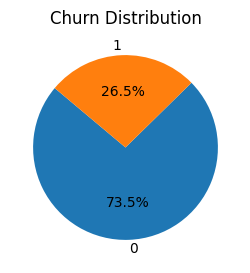

In [ ]:
churn_counts = data['Churn'].value_counts()
print(churn_counts)

plt.figure(figsize=(3, 3))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Churn Distribution')
plt.show()



Data set is unbalanced

In [ ]:
#balancing the dataset using SMOTE oversampling method

X= data.drop('Churn',axis='columns')
y=data['Churn']
y.value_counts()

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X,y)

y_sm.value_counts()

0    5174
1    5174
Name: Churn, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm,y_sm,test_size=0.2,random_state=15, stratify=y_sm)

### ANN

In [ ]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(26, input_dim=26, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)

    print(model.evaluate(X_test, y_test))

    y_preds_ann = model.predict(X_test)
    y_preds_ann = np.round(y_preds_ann)

    print("Classification Report: \n", classification_report(y_test, y_preds_ann))

    return y_preds_ann

In [ ]:
y_preds_ann = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 [==============================] - 1s 1ms/step - loss: 0.5544 - accuracy: 0.7223
Epoch 2/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4727 - accuracy: 0.7784
Epoch 3/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4649 - accuracy: 0.7806
Epoch 4/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4589 - accuracy: 0.7823
Epoch 5/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4560 - accuracy: 0.7842
Epoch 6/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4531 - accuracy: 0.7839
Epoch 7/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4482 - accuracy: 0.7862
Epoch 8/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4454 - accuracy: 0.7873
Epoch 9/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4409 - accuracy: 0.7922
Epoch 10/100
259/259 [==============================] - 0s 1ms/step - loss: 0.4380 - accura

### SVC

In [ ]:
def SVC_model(X_train, y_train, X_test, y_test):
    model = SVC(kernel='rbf')
    model.fit(X_train, y_train)

    y_preds_svc = model.predict(X_test)

    print("Classification Report:\n", classification_report(y_test, y_preds_svc))

    return y_preds_svc

In [ ]:
y_preds_svc = SVC_model (X_train, y_train, X_test, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.77      0.79      1035
           1       0.78      0.83      0.80      1035

    accuracy                           0.80      2070
   macro avg       0.80      0.80      0.80      2070
weighted avg       0.80      0.80      0.80      2070



### Random forest

In [ ]:
def RandomForest_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train, y_train)

    y_preds_rf = model.predict(X_test)

    print("Classification Report:\n", classification_report(y_test, y_preds_rf))

    return y_preds_rf

In [ ]:
y_preds_rf = RandomForest_model(X_train, y_train, X_test, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82      1035
           1       0.81      0.85      0.83      1035

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



### Naive Bayes

In [ ]:
def NaiveBayes_model(X_train, y_train, X_test, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)

    y_preds_nb = model.predict(X_test)

    print("Classification Report:\n", classification_report(y_test, y_preds_nb))

    return y_preds_nb

In [ ]:
y_preds_nb = NaiveBayes_model(X_train, y_train, X_test, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75      1035
           1       0.74      0.81      0.77      1035

    accuracy                           0.76      2070
   macro avg       0.76      0.76      0.76      2070
weighted avg       0.76      0.76      0.76      2070



### Logistic regression

In [ ]:
def LogisticRegression_model(X_train, y_train, X_test, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_preds_lr = model.predict(X_test)

    print("Classification Report:\n", classification_report(y_test, y_preds_lr))

    return y_preds_lr

In [ ]:
y_preds_lr = LogisticRegression_model(X_train, y_train, X_test, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      1035
           1       0.79      0.83      0.81      1035

    accuracy                           0.80      2070
   macro avg       0.80      0.80      0.80      2070
weighted avg       0.80      0.80      0.80      2070



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Decision tree

In [ ]:
def DecisionTree_model(X_train, y_train, X_test, y_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    y_preds_dt = model.predict(X_test)

    print("Classification Report:\n", classification_report(y_test, y_preds_dt))

    return y_preds_dt

In [ ]:
y_preds_dt = DecisionTree_model(X_train, y_train, X_test, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.76      1035
           1       0.76      0.77      0.77      1035

    accuracy                           0.76      2070
   macro avg       0.76      0.76      0.76      2070
weighted avg       0.76      0.76      0.76      2070



In [ ]:
filename = "model.sav"
joblib.dump (y_preds_rf, filename)

['model.sav']